In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import AveragePooling2D, GlobalMaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob

In [ ]:
#Normal Images Directories

trainFolder = '/content/drive/My Drive/COVID-CT/Train'

In [ ]:
# trainDataLBP = []
# trainLabel = [] #temporary storage
# trainLabelLBP = []

INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BS,
                                                           directory = trainFolder,
                                                           shuffle=True,
                                                           target_size=(255, 255),
                                                           class_mode='categorical',
                                                           subset='training')

validation_data_gen = train_image_generator.flow_from_directory(batch_size=BS,
                                                           directory = trainFolder,
                                                           shuffle=True,
                                                           target_size=(255, 255),
                                                           class_mode='categorical',
                                                           subset='validation')

Found 336 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = GlobalMaxPool2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="XX")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
# H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX)/10, validation_data=(testX, testY), validation_steps=len(testX)/10, epochs=10)
H = model.fit(train_data_gen, steps_per_epoch=train_data_gen.samples//BS, validation_data=validation_data_gen, validation_steps=validation_data_gen.samples//BS, epochs = EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/25
42/42 [==============================] - 261s 6s/step - loss: 0.7733 - accuracy: 0.5863 - val_loss: 0.6739 - val_accuracy: 0.5750
Epoch 2/25
42/42 [==============================] - 255s 6s/step - loss: 0.6343 - accuracy: 0.6399 - val_loss: 0.6801 - val_accuracy: 0.5500
Epoch 3/25
42/42 [==============================] - 255s 6s/step - loss: 0.6060 - accuracy: 0.6994 - val_loss: 0.6023 - val_accuracy: 0.7125
Epoch 4/25
42/42 [==============================] - 255s 6s/step - loss: 0.5741 - accuracy: 0.6964 - val_loss: 0.5927 - val_accuracy: 0.7375
Epoch 5/25
42/42 [==============================] - 255s 6s/step - loss: 0.5032 - accuracy: 0.7440 - val_loss: 0.5453 - val_accuracy: 0.7125
Epoch 6/25
42/42 [==============================] - 256s 6s/step - loss: 0.4772 - accuracy: 0.7708 - val_loss: 0.5734 - val_accuracy: 0.7000
Epoch 7/25
42/42 [==============================] - 256s 6s/step - loss: 0.4625 - accuracy: 0.7857 - val

In [ ]:
avg = (sum(H.history["val_accuracy"])/len(H.history["val_accuracy"]))
avg

0.6989999985694886

In [ ]:
Y_pred = model.predict(validation_data_gen, validation_data_gen.samples // BS+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data_gen.classes, y_pred))

Confusion Matrix
[[30 16]
 [23 14]]


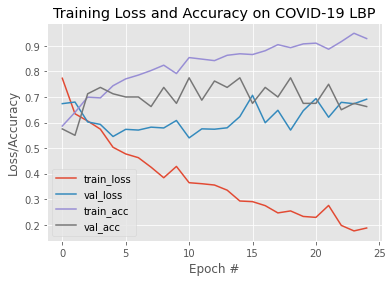

In [ ]:
            # plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 LBP")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.ylim(0.2, 0.75)
#plt.savefig(args["plot"])

In [ ]:
# # serialize the model to disk
# print("[INFO] saving COVID-19 detector model...")
# model.save("/content/drive/My Drive/COVID-CT/Models/normalModel.h5")

[INFO] saving COVID-19 detector model...


In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/COVID-CT/Models/normalModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("normalModel.h5")
print("Saved model to disk")

Saved model to disk
